In [1]:
#USE A 1-D CONVOLUTIONAL NEURAL NETWORK

In [2]:
#load the data
import os
import pandas as pd

os.chdir('/Users/jacksonwalters/tensorflow_datasets')
filepath_dict = {'tweet':   'labeled_tweets/all_labeled_tweets.txt'}

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, names=['sentence', 'label'], sep='\t')
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence    Tune in 11:30 ET tomorrow for a live webcast o...
label                                                       0
source                                                  tweet
Name: 0, dtype: object


In [3]:
#vectorize the data and split into train/test
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split

tokenizer = Tokenizer(num_words=5000)
#slice the df to get yelp sentences
df_tweet = df[df['source'] == 'tweet']
sentences = df_tweet['sentence'].values
#tweet sentence sentiment labels. 0 = negative, 1 = positive
y = df_tweet['label'].values
#split the sentences into training data and test data
sentences_train, sentences_test, y_train, y_test = train_test_split(sentences, y, test_size=0.25, random_state=1000)
#vectorize the sentences
tokenizer.fit_on_texts(sentences_train)
X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)
# Adding 1 because of reserved 0 index
vocab_size = len(tokenizer.word_index) + 1 
#pad_sequences
maxlen = 100
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [4]:
vocab_size

19415

In [5]:
#plotting function
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [6]:
#build the model
from keras import Sequential
from keras import layers

embedding_dim = 100

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, input_length=maxlen))
model.add(layers.Conv1D(128, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

Metal device set to: Apple M1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 100, 100)          1941500   
                                                                 
 conv1d (Conv1D)             (None, 96, 128)           64128     
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 10)                1290      
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 2,006,929
Trainable params: 2,006,929
Non-trainable params: 0
________________

2022-01-13 15:51:33.544868: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-01-13 15:51:33.544953: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Epoch 1/2


2022-01-13 15:51:33.680091: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-01-13 15:51:33.833832: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


905/905 [==============================] - ETA: 0s - loss: 0.1254 - accuracy: 0.9478

2022-01-13 15:51:48.338470: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


905/905 [==============================] - 16s 16ms/step - loss: 0.1254 - accuracy: 0.9478 - val_loss: 0.0694 - val_accuracy: 0.9745
Epoch 2/2
905/905 [==============================] - 14s 16ms/step - loss: 0.0152 - accuracy: 0.9946 - val_loss: 0.0979 - val_accuracy: 0.9688
Training Accuracy: 0.9986
Testing Accuracy:  0.9688


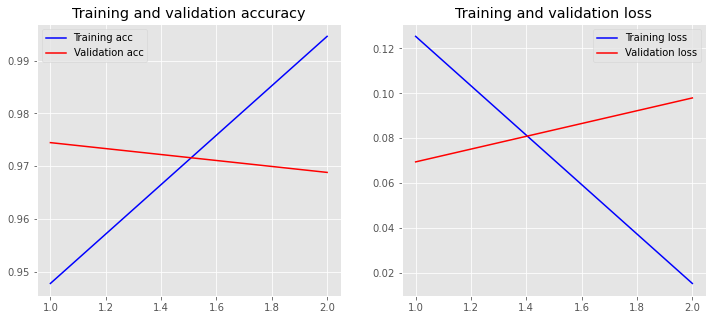

In [7]:
history = model.fit(X_train, y_train,
                    epochs=2,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=10)
loss, accuracy = model.evaluate(X_train, y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

In [47]:
#test examples
ex_sent = "fake news"
X_ex_sent = tokenizer.texts_to_sequences([ex_sent])
model.predict(pad_sequences(X_ex_sent, padding='post', maxlen=maxlen))

array([[0.99981135]], dtype=float32)

In [49]:
model.save('/Users/jacksonwalters/Desktop/cnn_model')

INFO:tensorflow:Assets written to: /Users/jacksonwalters/Desktop/cnn_model/assets
